In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dython as dy
import plotly.express as px
from pandas_profiling import ProfileReport
from sklearn.preprocessing import MultiLabelBinarizer, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, train_test_split
from xgboost import XGBRegressor
import plotly.figure_factory as ff
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns

# Loading the dataset

In [62]:
df = pd.read_csv('./data/dataset.csv')
print(df.shape)
df.head(5)

(1000, 9)


,id,water,uv,area,fertilizer_usage,yield,pesticides,region,categories
0,169,5.615,65.281,3.230,0,7.977,8.969,0,"b,a,c"
1,476,7.044,73.319,9.081,0,23.009,7.197,0,"c,a,d"
2,152,5.607,60.038,2.864,2,23.019,7.424,0,"d,a"
3,293,9.346,64.719,2.797,2,28.066,1.256,0,d
4,10,7.969,NaN,5.407,1,29.140,0.274,0,"c,d"


In [63]:
# Setting id as index
df.set_index('id', inplace=True)

In [64]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

water                4.17400
uv                  14.05200
area                 3.60325
fertilizer_usage     2.00000
yield               32.94750
pesticides           3.11150
region               3.00000
dtype: float64


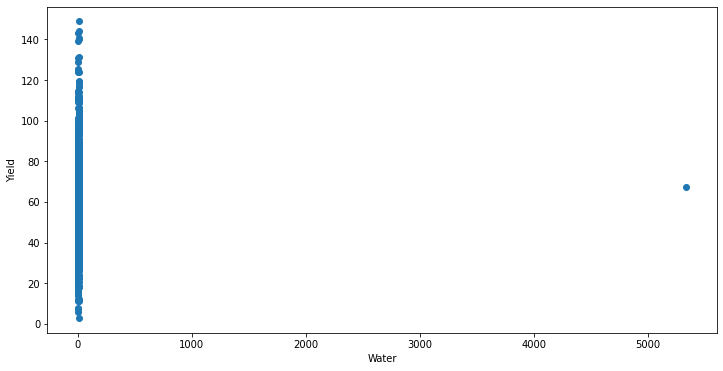

In [65]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df['water'], df['yield'])
ax.set_xlabel('Water')
ax.set_ylabel('Yield')
plt.show()

In [66]:
# cols_for_outlier_detection = ['water', 'uv', 'area', 'pesticides']
# # Treatment of outliers
#
# def treat_outliers(col):
#
#     low = df[col].quantile(0.01)
#     high = df[col].quantile(0.99)
#
#     df[col] = np.where(df[col] < low, low,df[col])
#     df[col] = np.where(df[col] > high, high,df[col])
#     print(f'Skewness after removing outliers from col {col} is {df[col].skew()}')
#
# for col in cols_for_outlier_detection:
#     treat_outliers(col)
#
#
# for col in cols_for_outlier_detection:
#     df[col] = df.groupby('region')[col].transform(lambda x: x.fillna(x.mean()))

In [67]:
# df.isna().sum()

In [68]:
# scalar = RobustScaler()
# scalar.fit_transform(df[cols_for_outlier_detection])

In [99]:
# Now categorical variables

class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        print('INIT of categorical transformer')

    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self

    #Transformer method we wrote for this transformer
    def transform(self, X , y = None ):
        #Depending on constructor argument break dates column into specified units
        #using the helper functions written above
        X = pd.get_dummies(X, columns=['region'], dtype=np.int64)

        # Splitting the entries so that it can be ingested to binarizer
        X['categories'] = X['categories'].transform(lambda x: x.split(','))

        mlb = MultiLabelBinarizer()
        cats = pd.DataFrame(mlb.fit_transform(X['categories']),columns=mlb.classes_, index=X.index)

        # Renaming the column value
        cats.columns = 'pesticide_' + cats.columns.values
        X = pd.concat([X.drop(columns='categories'), cats], axis=1)

        print(f'>>>> After Categorical transform: feature set: {X.head(2)}')
        #returns numpy array
        return X.values

In [92]:
# Custom Transformer that extracts columns passed as argument to its constructor
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor
    def __init__( self, feature_names):
        print('>>>>>>> INIT of feature selector')
        self.feature_names = feature_names

    #Return self nothing else to do here
    def fit( self, X, y = None ):
        return self

    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        print('>>>>>> Selecting features')
        return X[self.feature_names]

In [90]:
# Will handle water, uv, area, pesticides- fill missing values and scale

class NumericalTransformer(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__( self):
        print('>>>>>INIT of NumericalTransformer')

    #Return self, nothing else to do here
    def fit( self, X, y = None ):
        return self

    #Custom transform method we wrote that creates aformentioned features and drops redundant ones
    def transform(self, X, y = None):

        for col in X.columns:
            # Adjusting outliers with their percentile values
            low = X[col].quantile(0.01)
            high = X[col].quantile(0.99)

            X[col] = np.where(X[col] < low, low,X[col])
            X[col] = np.where(X[col] > high, high,X[col])

            # # Filling the Missing Values
            # X[col] = X.groupby('region')[col].transform(lambda x: x.fillna(x.mean()))
        print(f'>>>> After numerical transform: feature set: {X.head(2)}')
        #returns a numpy array
        return X.values

In [72]:
df.head()

,water,uv,area,fertilizer_usage,yield,pesticides,region,categories
id,,,,,,,,
169,5.615,65.281,3.230,0,7.977,8.969,0,"b,a,c"
476,7.044,73.319,9.081,0,23.009,7.197,0,"c,a,d"
152,5.607,60.038,2.864,2,23.019,7.424,0,"d,a"
293,9.346,64.719,2.797,2,28.066,1.256,0,d
10,7.969,NaN,5.407,1,29.140,0.274,0,"c,d"


In [93]:
# Numerical features to pass down the numerical pipeline
numerical_features = ['water', 'uv', 'area', 'pesticides']

# Categorical features to pass donw the categorical pipeline
categorical_features = ['fertilizer_usage', 'region', 'categories']

#Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(numerical_features) ),

                                  ( 'num_transformer', NumericalTransformer() ),
                                    ('imputer', SimpleImputer(strategy = 'median') ),

                                  ( 'std_scaler', RobustScaler() ) ] )


#Defining the steps in the categorical pipeline
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features) ),

                                  ( 'cat_transformer', CategoricalTransformer() )] )


#Combining numerical and categorical pipeline into one full big pipeline horizontally
#using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ),

                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )


>>>>>>> INIT of feature selector
>>>>>INIT of NumericalTransformer
>>>>>>> INIT of feature selector
>>>>INIT of categorical transformer


In [156]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Leave it as a dataframe because our pipeline is called on a
#pandas dataframe to extract the appropriate columns, remember?
X = df.drop('yield', axis = 1)
#You can covert the target variable to numpy
y = df['yield'].values

X_train, X_test, y_train, y_test = train_test_split( X, y , test_size = 0.2 , random_state = 42 )

In [104]:
#The full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_m = Pipeline( steps = [ ( 'full_pipeline', full_pipeline),

                                  ( 'clf', LinearRegression() ) ] )

In [96]:
#Can call fit on it just like any other pipeline
full_pipeline_m.fit( X_train, y_train )

>>>>>> Selecting features
     a  b  c  d
id             
597  1  0  1  0
812  0  1  0  1
878  0  1  0  0
92   0  0  0  1
61   1  0  0  0
..  .. .. .. ..
584  0  1  0  0
28   1  0  0  0
496  0  0  1  0
966  0  1  1  0
628  1  0  1  1

[800 rows x 4 columns]
>>>> After Categorical transform: feature set:      fertilizer_usage  region_0  region_1  region_2  region_3  region_4  \
id                                                                        
597                 3         1         0         0         0         0   
812                 2         0         0         0         1         0   

     region_5  region_6  pesticide_a  pesticide_b  pesticide_c  pesticide_d  
id                                                                           
597         0         0            1            0            1            0  
812         0         0            0            1            0            1  
>>>>>> Selecting features
>>>> After numerical transform: feature set:      water 

Pipeline(steps=[('full_pipeline',
                 FeatureUnion(transformer_list=[('categorical_pipeline',
                                                 Pipeline(steps=[('cat_selector',
                                                                  FeatureSelector(feature_names=['fertilizer_usage',
                                                                                                 'region',
                                                                                                 'categories'])),
                                                                 ('cat_transformer',
                                                                  CategoricalTransformer())])),
                                                ('numerical_pipeline',
                                                 Pipeline(steps=[('num_selector',
                                                                  FeatureSelector(feature_names=['water',
                                 

In [97]:
#Can predict with it like any other pipeline
y_pred = full_pipeline_m.predict( X_test )

>>>>>> Selecting features
     a  b  c  d
id             
327  0  0  1  0
750  0  1  0  0
571  0  1  0  0
52   0  0  1  0
635  0  1  0  0
..  .. .. .. ..
801  0  0  1  0
824  1  1  1  1
907  0  0  1  0
954  0  1  0  0
329  0  0  1  0

[200 rows x 4 columns]
>>>> After Categorical transform: feature set:      fertilizer_usage  region_0  region_1  region_2  region_3  region_4  \
id                                                                        
327                 0         0         0         0         1         0   
750                 3         0         0         0         0         1   

     region_5  region_6  pesticide_a  pesticide_b  pesticide_c  pesticide_d  
id                                                                           
327         0         0            0            0            1            0  
750         0         0            0            1            0            0  
>>>>>> Selecting features
>>>> After numerical transform: feature set:      water 

In [101]:
# R2 score
r2_score(y_test, y_pred, multioutput='variance_weighted')

0.7122121965055047

In [102]:
#Confidence Interval of our Predictions will help us better understand the ouput of our model
from scipy import stats

confidence = 0.95
squared_errors = (y_pred-y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([12.02454728, 14.90058322])

In [157]:
estimators = {
    DummyRegressor(strategy="mean"):{},
    LinearRegression():{},
    RandomForestRegressor():{
        'clf__bootstrap': [True, False],
        'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
        'clf__max_features': ['auto', 'sqrt'],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__min_samples_split': [2, 5, 10],
        'clf__n_estimators': [100, 130, 180, 230]
    },
    # XGBRegressor():{
    #     "clf__n_estimators": [10, 50, 100],
    #     "clf__learning_rate": [0.1, 0.5],
    # }
}

In [158]:
class meta():
    # training meta data
    test_size = 0.30
    val_size = 0.25
    random_state = {'test': 20, 'val': 6}
    k_fold = 3
    scoring = 'r2'
    n_iter = 10

In [159]:
def train(regressors, Xtrain, ytrain, meta, verbose=0):
    best_estimators = {}
    for clf, params in tqdm(regressors.items()):

        # search across 100 different combinations, and use all available cores
        search_cv = RandomizedSearchCV(
            # pipeline
            estimator = Pipeline(
                steps=[ ( 'full_pipeline', full_pipeline),

                        ( 'clf', clf ) ]
            ),

            # cross validation
            cv = KFold(
                n_splits = meta.k_fold,
                shuffle = True,
                random_state = meta.random_state['val']
            ),

            # parameters
            param_distributions = params,

            scoring = meta.scoring,
            n_iter = meta.n_iter,
            random_state = meta.random_state['val'],
            n_jobs = -1,
            verbose = verbose,
        )

        # fit model
        search_cv.fit(Xtrain, ytrain)

        # best params and model
        search_cv.best_params_
        best_estimator = search_cv.best_estimator_
        best_estimators[clf] = best_estimator.named_steps['clf']

        print(f'Best Estimator {best_estimator}')
        print(f'Models'
              f' {best_estimators}')

    return search_cv


In [160]:
searchcv = train(regressors=estimators, Xtrain= X_train, ytrain=y_train, meta=meta())

  0%|          | 0/3 [00:00<?, ?it/s]/home/harshal/PycharmProjects/AltaMLTechnical/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]/home/harshal/PycharmProjects/AltaMLTechnical/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


>>>>>>> INIT of feature selector
>>>>INIT of categorical transformer
>>>>>>> INIT of feature selector
>>>>>INIT of NumericalTransformer
>>>>>>> INIT of feature selector
>>>>INIT of categorical transformer
>>>>>>> INIT of feature selector
>>>>>INIT of NumericalTransformer
>>>>>>> INIT of feature selector
>>>>INIT of categorical transformer
>>>>>>> INIT of feature selector
>>>>>INIT of NumericalTransformer
>>>>>>> INIT of feature selector
>>>>INIT of categorical transformer
>>>>>>> INIT of feature selector
>>>>>INIT of NumericalTransformer
>>>>>>> INIT of feature selector
>>>>INIT of categorical transformer
>>>>>>> INIT of feature selector
>>>>>INIT of NumericalTransformer
>>>>>>> INIT of feature selector
>>>>INIT of categorical transformer
>>>>>>> INIT of feature selector
>>>>>INIT of NumericalTransformer
>>>>>> Selecting features
     a  b  c  d
id             
597  1  0  1  0
812  0  1  0  1
878  0  1  0  0
92   0  0  0  1
61   1  0  0  0
..  .. .. .. ..
584  0  1  0  0
28   1  0  0  

In [163]:
searchcv.score(X_test,y_test)

>>>>>> Selecting features
     a  b  c  d
id             
327  0  0  1  0
750  0  1  0  0
571  0  1  0  0
52   0  0  1  0
635  0  1  0  0
..  .. .. .. ..
801  0  0  1  0
824  1  1  1  1
907  0  0  1  0
954  0  1  0  0
329  0  0  1  0

[200 rows x 4 columns]
>>>> After Categorical transform: feature set:      fertilizer_usage  region_0  region_1  region_2  region_3  region_4  \
id                                                                        
327                 0         0         0         0         1         0   
750                 3         0         0         0         0         1   

     region_5  region_6  pesticide_a  pesticide_b  pesticide_c  pesticide_d  
id                                                                           
327         0         0            0            0            1            0  
750         0         0            0            1            0            0  
>>>>>> Selecting features
>>>> After numerical transform: feature set:      water 

0.8335427034227463

In [164]:
searchcv.predict(X_test)

>>>>>> Selecting features
     a  b  c  d
id             
327  0  0  1  0
750  0  1  0  0
571  0  1  0  0
52   0  0  1  0
635  0  1  0  0
..  .. .. .. ..
801  0  0  1  0
824  1  1  1  1
907  0  0  1  0
954  0  1  0  0
329  0  0  1  0

[200 rows x 4 columns]
>>>> After Categorical transform: feature set:      fertilizer_usage  region_0  region_1  region_2  region_3  region_4  \
id                                                                        
327                 0         0         0         0         1         0   
750                 3         0         0         0         0         1   

     region_5  region_6  pesticide_a  pesticide_b  pesticide_c  pesticide_d  
id                                                                           
327         0         0            0            0            1            0  
750         0         0            0            1            0            0  
>>>>>> Selecting features
>>>> After numerical transform: feature set:      water 

array([ 37.48365281, 110.29512868, 109.4508534 ,  52.99004084,
        56.28947711,  79.0466514 ,  89.18317651, 114.85937318,
        52.34454519,  45.35270588,  30.62789076,  30.63659861,
        90.33265167,  88.82059483,  76.48359279,  54.92193361,
        34.60647565,  59.1906462 ,  46.78606502,  32.62272686,
        37.60956932,  66.85088225,  49.8021781 ,  37.18595366,
        14.88533511,  15.7220194 ,  56.374228  ,  84.05868583,
        57.44715127,  68.21136407,  43.80373377,  48.3483528 ,
        80.8353333 ,  66.38961795,  51.03626318,  87.93775037,
        64.025688  ,  66.7582538 ,  56.42488547,  29.08749277,
        44.96750547,  37.69591728,  42.0727575 ,  61.67575391,
        49.5475109 ,  40.31737955,  57.92225025,  65.38820725,
        63.95611909,  50.5197862 ,  66.57281187,  51.97124986,
        27.48591011,  55.68178371,  33.59199342,  55.81933549,
        82.80637406,  38.56136196,  35.38271302,  36.55342739,
        39.12740093,  88.79380741,  41.02849517,  28.54

In [165]:
r2_score(y_test, searchcv.predict(X_test))

>>>>>> Selecting features
     a  b  c  d
id             
327  0  0  1  0
750  0  1  0  0
571  0  1  0  0
52   0  0  1  0
635  0  1  0  0
..  .. .. .. ..
801  0  0  1  0
824  1  1  1  1
907  0  0  1  0
954  0  1  0  0
329  0  0  1  0

[200 rows x 4 columns]
>>>> After Categorical transform: feature set:      fertilizer_usage  region_0  region_1  region_2  region_3  region_4  \
id                                                                        
327                 0         0         0         0         1         0   
750                 3         0         0         0         0         1   

     region_5  region_6  pesticide_a  pesticide_b  pesticide_c  pesticide_d  
id                                                                           
327         0         0            0            0            1            0  
750         0         0            0            1            0            0  
>>>>>> Selecting features
>>>> After numerical transform: feature set:      water 

0.8335427034227463

In [174]:
X_train.columns

Index(['water', 'uv', 'area', 'fertilizer_usage', 'pesticides', 'region',
       'categories'],
      dtype='object')

<AxesSubplot:>

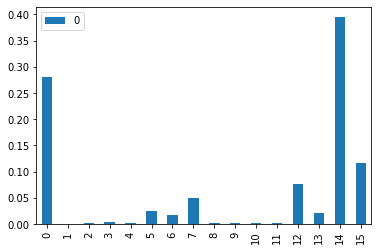

In [175]:
pd.DataFrame(searchcv.best_estimator_.named_steps['clf'].feature_importances_).plot(kind='bar')


Hyperopt sklean

In [197]:
# example of hyperopt-sklearn for the housing regression dataset
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe
# load dataset

# define search
model = HyperoptEstimator(regressor=any_regressor('reg'), loss_fn=r2_score, algo=tpe.suggest, trial_timeout=30, max_evals=50)

#
# # perform the search
# model.fit(X_train, y_train)
# # summarize performance
# mae = model.score(X_test, y_test)
# print("MAE: %.3f" % mae)
# # summarize the best model
# print(model.best_model())


hypipeline = Pipeline( steps = [ ( 'full_pipeline', full_pipeline),

                                  ( 'clf', model ) ] )

In [183]:
full_pipeline.fit_transform(X_train, y_train)

>>>>>> Selecting features
     a  b  c  d
id             
597  1  0  1  0
812  0  1  0  1
878  0  1  0  0
92   0  0  0  1
61   1  0  0  0
..  .. .. .. ..
584  0  1  0  0
28   1  0  0  0
496  0  0  1  0
966  0  1  1  0
628  1  0  1  1

[800 rows x 4 columns]
>>>> After Categorical transform: feature set:      fertilizer_usage  region_0  region_1  region_2  region_3  region_4  \
id                                                                        
597                 3         1         0         0         0         0   
812                 2         0         0         0         1         0   

     region_5  region_6  pesticide_a  pesticide_b  pesticide_c  pesticide_d  
id                                                                           
597         0         0            1            0            1            0  
812         0         0            0            1            0            1  
>>>>>> Selecting features
>>>> After numerical transform: feature set:      water 

array([[ 3.        ,  1.        ,  0.        , ..., -1.61304029,
        -0.55151429, -0.94328505],
       [ 2.        ,  0.        ,  0.        , ...,  0.20067425,
        -1.09496179,  0.97929454],
       [ 2.        ,  0.        ,  0.        , ..., -0.34528488,
         1.2217662 , -1.03892299],
       ...,
       [ 3.        ,  0.        ,  0.        , ...,  0.        ,
         0.86880838,  1.55217285],
       [ 2.        ,  0.        ,  0.        , ...,  1.2471456 ,
         0.60472686, -0.42180211],
       [ 5.        ,  0.        ,  1.        , ...,  0.09905195,
        -1.17279932,  0.79008102]])

FeatureUnion(transformer_list=[('categorical_pipeline',
                                Pipeline(steps=[('cat_selector',
                                                 FeatureSelector(feature_names=['fertilizer_usage',
                                                                                'region',
                                                                                'categories'])),
                                                ('cat_transformer',
                                                 CategoricalTransformer())])),
                               ('numerical_pipeline',
                                Pipeline(steps=[('num_selector',
                                                 FeatureSelector(feature_names=['water',
                                                                                'uv',
                                                                                'area',
                                                               

In [201]:
#Can call fit on it just like any other pipeline
model.fit(full_pipeline.fit_transform(X_train, y_train), y_train)

>>>>>> Selecting features
     a  b  c  d
id             
597  1  0  1  0
812  0  1  0  1
878  0  1  0  0
92   0  0  0  1
61   1  0  0  0
..  .. .. .. ..
584  0  1  0  0
28   1  0  0  0
496  0  0  1  0
966  0  1  1  0
628  1  0  1  1

[800 rows x 4 columns]
>>>> After Categorical transform: feature set:      fertilizer_usage  region_0  region_1  region_2  region_3  region_4  \
id                                                                        
597                 3         1         0         0         0         0   
812                 2         0         0         0         1         0   

     region_5  region_6  pesticide_a  pesticide_b  pesticide_c  pesticide_d  
id                                                                           
597         0         0            1            0            1            0  
812         0         0            0            1            0            1  
>>>>>> Selecting features
>>>> After numerical transform: feature set:      water 

job exception: __init__() got an unexpected keyword argument 'presort'



TypeError: __init__() got an unexpected keyword argument 'presort'

In [199]:
#Can predict with it like any other pipeline
model.score(full_pipeline.fit_transform(X_test, y_test), y_test)



>>>>>> Selecting features
     a  b  c  d
id             
327  0  0  1  0
750  0  1  0  0
571  0  1  0  0
52   0  0  1  0
635  0  1  0  0
..  .. .. .. ..
801  0  0  1  0
824  1  1  1  1
907  0  0  1  0
954  0  1  0  0
329  0  0  1  0

[200 rows x 4 columns]
>>>> After Categorical transform: feature set:      fertilizer_usage  region_0  region_1  region_2  region_3  region_4  \
id                                                                        
327                 0         0         0         0         1         0   
750                 3         0         0         0         0         1   

     region_5  region_6  pesticide_a  pesticide_b  pesticide_c  pesticide_d  
id                                                                           
327         0         0            0            0            1            0  
750         0         0            0            1            0            0  
>>>>>> Selecting features
>>>> After numerical transform: feature set:      water 

NotFittedError: This KNeighborsRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [193]:
model.best_model()

{'learner': RandomForestRegressor(max_features=0.8134277620557027, n_estimators=26,
                       n_jobs=1, random_state=0, verbose=False),
 'preprocs': (Normalizer(),),
 'ex_preprocs': ()}

svr
svr_linear
svr_rbf
svr_poly
svr_sigmoid

knn_regression

ada_boost_regression
gradient_boosting_regression

random_forest_regression
extra_trees_regression

sgd_regression

xgboost_regression
LGBM Regressor

In [ ]:
HyperoptEstimator()